# Testing the model

In [2]:
import pandas as pd
import numpy as np
import os

import torch
from IPython.display import Image  
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
from roboflow import Roboflow
import matplotlib.pyplot as plt

random.seed(108)

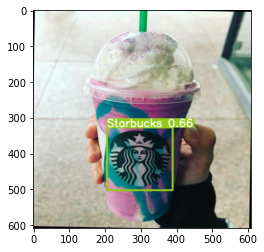

In [6]:
""" Here we can display our predictions on the images"""

detections_dir = "yolov5/runs/detect/exp11/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

## Defining the functions to evaluate IOU

As IOU is not directly returned among the metrics, we created our own formulas. The weighterd IOU also takes into consideration whether the prediction was right or wrong (the IOU in this case is zero when the image is wrongly predicted

In [7]:
def readFile(fileName):
    fileObj = open(fileName, "r") #opens the file in read mode
    lbs = fileObj.read().splitlines()
    llbs = [[float(fl) for fl in lb.split()] for lb in lbs] #puts the file into an array
    fileObj.close()
    return llbs

def getCoordinates(path): 
    
    labels = os.listdir(path)

    res = {}


    for label in labels: 
        img = label.replace(".txt", ".jpg")
        res[img] = readFile(path + label)

    df = pd.DataFrame(columns = ['image', 'class', 'x', 'y', 'w', 'h'])
    i = 0
    for key, val in res.items(): 
        for v in val: 
            cls, x, y, w, h = (v)
            df.loc[i] = {'image': key, 'class': cls, 'x' : x, 'y': y, 'w': w, 'h': h}
            i += 1
    return df

def unBoxing(cord): 
    x, y, w, h = (cord)
    
    w = w/2
    h = h/2
    
    box = [x-w, y-h, x+w, y+h]
    
    return box

def calc_iou(cordA, cordB):
    
    boxA = unBoxing(cordA)
    boxB = unBoxing(cordB)
    
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth===
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


In [8]:
path_pred = 'yolov5/runs/detect/exp11/labels/'
path_true = 'data_yolov5/test/labels/'


df_pred = getCoordinates(path_pred)
df_true = getCoordinates(path_true)

In [9]:
df_all = pd.merge(df_pred, df_true, how = 'left', on = 'image', suffixes = ('_pred', '_true'))

df_all['iou'] = 0

for i in range(df_all.shape[0]):
    row = df_all.iloc[i]

    cols = ['x', 'y', 'w', 'h']
    cordA = row[[cc + '_pred' for cc in cols]]
    cordB = row[[cc + '_true' for cc in cols]]
    
    iou = calc_iou(cordA, cordB)
    
    df_all['iou'].iloc[i] = iou



/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# For the weighted iou
correct = []
for i in range(len(df_all)):
    if df_all.loc[i, 'class_pred'] == df_all.loc[i, 'class_true']:
        correct.append(1)
    else:
        correct.append(0)
df_all['correct'] = correct

df_all['weighted_iou'] = df_all.correct * df_all.iou

In [11]:
print(f'IOU tot: {df_all.iou.mean()}')

print(f'IOU weighted: {df_all.weighted_iou.mean()}')

IOU tot: 0.9025617249390867
IOU weighted: 0.8960067235823628


In [12]:
df_all.groupby('class_true').agg({'iou': 'mean'})

,iou
class_true,
0.0,0.880664
1.0,0.926974
2.0,0.894508
3.0,0.931509
4.0,0.915317
5.0,0.934011
6.0,0.906355
7.0,0.879792
8.0,0.854437


In [13]:
df_all.groupby('class_true').agg({'weighted_iou': 'mean'})

,weighted_iou
class_true,
0.0,0.877247
1.0,0.918804
2.0,0.883847
3.0,0.927352
4.0,0.903644
5.0,0.930096
6.0,0.898582
7.0,0.877551
8.0,0.842146
